<a href="https://colab.research.google.com/github/syedanida/deep-learning-multimodal-colabs/blob/main/3_Transfer_Learn_Video_Classification_with_MovieNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Classification using Transfer Learning


In [4]:
!pip install -q tensorflow tensorflow_hub opencv-python

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [6]:
# Function to extract frames from video
def extract_frames(video_path, num_frames=64):
    """Extract frames from video for classification."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print(f"Error: Could not read frames from {video_path}")
        return None

    # Sample frames evenly from the video
    indices = np.linspace(0, max(0, total_frames - 1), num_frames).astype(int)

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)

    cap.release()

    # If we have fewer frames than requested, repeat the last frame
    while len(frames) < num_frames:
        frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))

    return np.array(frames)

In [7]:
# Download a sample video
!wget -q -O sample_video.mp4 "https://test-videos.co.uk/vids/bigbuckbunny/mp4/h264/360/Big_Buck_Bunny_360_10s_1MB.mp4"

In [8]:
# Alternative: Create a simple test video
def create_test_video():
    """Create a simple test video."""
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('test_video.mp4', fourcc, 30.0, (224, 224))

    for i in range(90):  # 3 seconds at 30 fps
        frame = np.zeros((224, 224, 3), dtype=np.uint8)
        # Draw moving circle
        x = int(112 + 80 * np.sin(i * 0.1))
        y = int(112 + 80 * np.cos(i * 0.1))
        cv2.circle(frame, (x, y), 20, (255, 255, 255), -1)
        cv2.line(frame, (112, 112), (x, y), (128, 128, 128), 2)
        out.write(frame)

    out.release()
    return 'test_video.mp4'

Extracted 64 frames


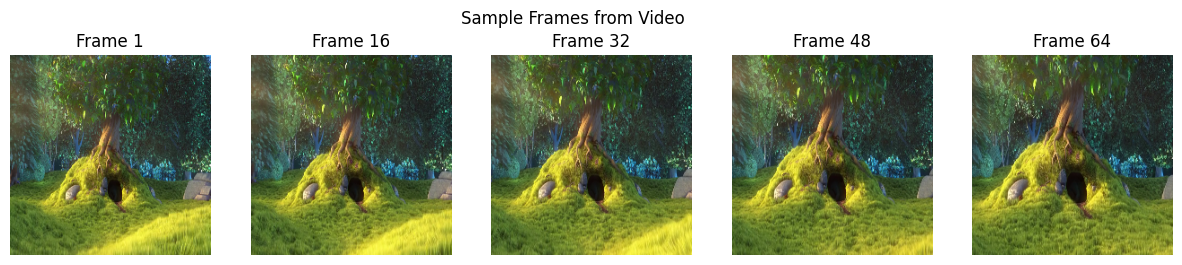

In [9]:
# Check if video exists, create one if not
if not os.path.exists('sample_video.mp4'):
    print("Creating test video...")
    video_path = create_test_video()
else:
    video_path = 'sample_video.mp4'

# Extract frames
frames = extract_frames(video_path)

if frames is not None:
    print(f"Extracted {len(frames)} frames")

    # Visualize sample frames
    plt.figure(figsize=(15, 3))
    frame_indices = np.linspace(0, len(frames)-1, 5).astype(int)
    for i, idx in enumerate(frame_indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(frames[idx])
        plt.axis('off')
        plt.title(f'Frame {idx+1}')
    plt.suptitle('Sample Frames from Video')
    plt.show()

In [10]:
# Load Kinetics-400 labels
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
try:
    labels_path = tf.keras.utils.get_file("labels.txt", KINETICS_URL)
    with open(labels_path) as f:
        labels = [line.strip() for line in f.readlines()]
    print(f"Loaded {len(labels)} action labels")
except Exception as e:
    print(f"Error loading labels: {e}")
    labels = [f"Action_{i}" for i in range(400)]  # Fallback labels

Loaded 400 action labels


In [11]:
# Load and use I3D model correctly
print("\n--- Using I3D Model ---")
try:
    # Load the I3D model
    i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1")

    # Get the default signature
    i3d_model = i3d.signatures['default']

    # Preprocess frames for I3D
    # I3D expects float32 values in range [-1, 1]
    preprocessed_frames = frames.astype(np.float32) / 127.5 - 1.0

    # Add batch dimension
    video_batch = np.expand_dims(preprocessed_frames, 0)

    # Convert to tf.constant with correct dtype
    video_tensor = tf.constant(video_batch, dtype=tf.float32)

    # Make prediction
    # I3D expects input shape: [batch_size, num_frames, height, width, 3]
    outputs = i3d_model(video_tensor)
    predictions = outputs['default'].numpy()[0]

    # Get top 5 predictions
    top_5_indices = np.argsort(predictions)[-5:][::-1]

    print("\nTop 5 predicted actions:")
    for idx in top_5_indices:
        print(f"{labels[idx]}: {predictions[idx]:.3f}")

except Exception as e:
    print(f"Error with I3D model: {e}")
    print("Falling back to alternative approach...")

# Alternative: Use MobileNetV2 for video classification
print("\n--- Alternative: Video Classification with MobileNetV2 ---")


--- Using I3D Model ---

Top 5 predicted actions:
scuba diving: 9.202
singing: 8.158
playing harp: 6.590
playing didgeridoo: 6.353
taking a shower: 5.917

--- Alternative: Video Classification with MobileNetV2 ---


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Dropout, GlobalAveragePooling2D

In [13]:
def create_video_classifier(num_classes=10):
    """Create a video classifier using MobileNetV2 and LSTM."""
    # Base model for feature extraction
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Model architecture
    inputs = tf.keras.Input(shape=(None, 224, 224, 3))

    # TimeDistributed wrapper applies the base_model to each frame
    x = TimeDistributed(base_model)(inputs)
    x = TimeDistributed(GlobalAveragePooling2D())(x)

    # LSTM for temporal processing
    x = LSTM(256)(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [14]:
# Create the model
model = create_video_classifier(10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\nCustom video classifier model created!")
model.summary()


Custom video classifier model created!


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, 224, 224, │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, None, 7, 7,     │     2,257,984 │
│ (TimeDistributed)               │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, None, 1280)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,866,058 (14.75 MB)

 Trainable params: 1,608,074 (6.13 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Simple CNN+LSTM model for video classification
print("\n--- Simple CNN+LSTM Model ---")

def create_simple_video_model(num_classes=10):
    """Create a simpler video classification model."""
    inputs = tf.keras.Input(shape=(None, 224, 224, 3))

    # Simple CNN feature extractor
    x = TimeDistributed(tf.keras.layers.Conv2D(32, 3, activation='relu'))(inputs)
    x = TimeDistributed(tf.keras.layers.MaxPooling2D())(x)
    x = TimeDistributed(tf.keras.layers.Conv2D(64, 3, activation='relu'))(x)
    x = TimeDistributed(tf.keras.layers.MaxPooling2D())(x)
    x = TimeDistributed(tf.keras.layers.Conv2D(128, 3, activation='relu'))(x)
    x = TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())(x)

    # LSTM for temporal modeling
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

simple_model = create_simple_video_model(10)
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


--- Simple CNN+LSTM Model ---


In [16]:
print("Simple video classifier created!")

# Create synthetic training data
def create_synthetic_video_data(num_videos=20, num_frames=16, num_classes=10):
    """Create synthetic video data for demonstration."""
    X = []
    y = []

    for _ in range(num_videos):
        # Create random video frames
        video = np.random.rand(num_frames, 224, 224, 3).astype(np.float32)
        X.append(video)

        # Random one-hot label
        label = np.zeros(num_classes)
        label[np.random.randint(0, num_classes)] = 1
        y.append(label)

    return np.array(X), np.array(y)

# Generate synthetic data
X_train, y_train = create_synthetic_video_data()
print(f"\nSynthetic data shape: {X_train.shape}")

# Train the simple model (1 epoch for demo)
print("\nTraining simple model...")
history = simple_model.fit(X_train, y_train, batch_size=2, epochs=1, verbose=1)

# Test on real video
if frames is not None:
    # Prepare video for prediction
    test_frames = frames[:16].astype(np.float32) / 255.0  # Normalize
    test_video = np.expand_dims(test_frames, 0)

    # Make prediction
    predictions = simple_model.predict(test_video)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    print(f"\nSimple model prediction: Class {predicted_class} (confidence: {confidence:.2%})")

Simple video classifier created!

Synthetic data shape: (20, 16, 224, 224, 3)

Training simple model...
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.2795 - loss: 2.2691
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Simple model prediction: Class 0 (confidence: 14.46%)


In [17]:
# Demonstrate video augmentation
def augment_video(frames):
    """Apply augmentation to video frames."""
    augmented = []

    for frame in frames:
        # Random brightness
        frame = tf.image.random_brightness(frame, 0.2)
        # Random contrast
        frame = tf.image.random_contrast(frame, 0.8, 1.2)
        # Random flip with 50% probability
        if np.random.random() > 0.5:
            frame = tf.image.flip_left_right(frame)
        augmented.append(frame)

    return tf.stack(augmented)

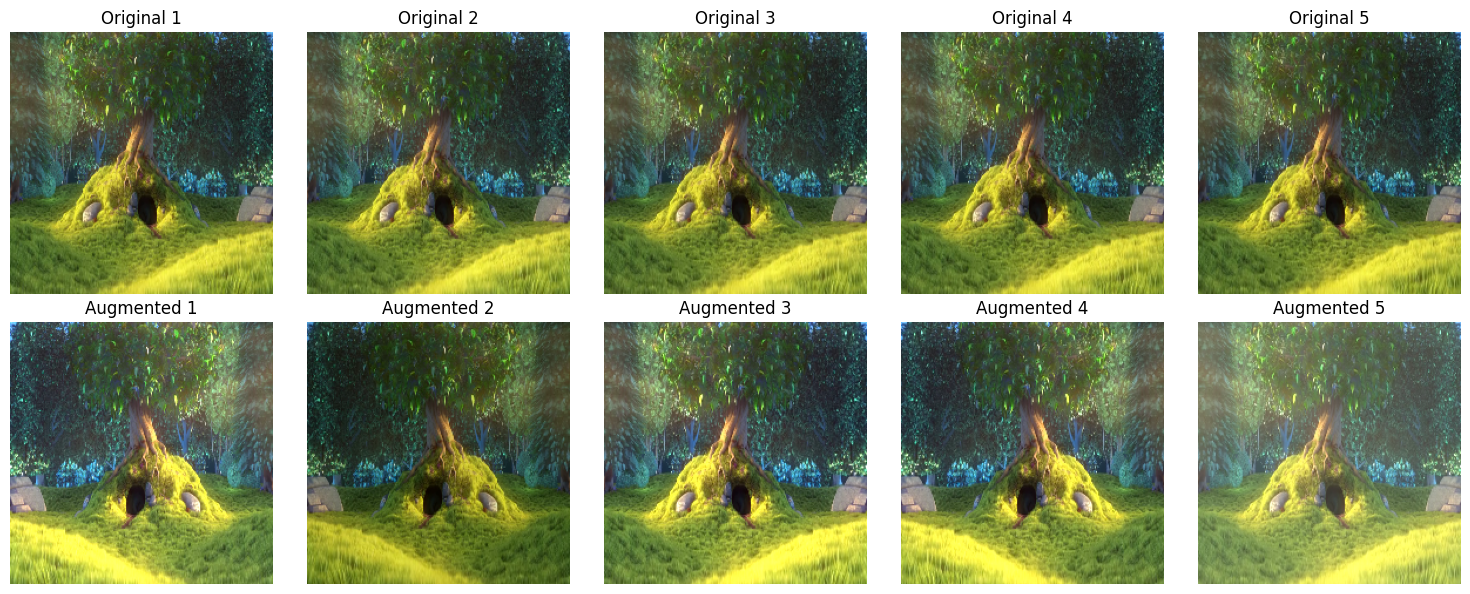

In [18]:
# Show augmented frames
if frames is not None:
    augmented = augment_video(frames[:5].astype(np.float32) / 255.0)

    plt.figure(figsize=(15, 6))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(frames[i])
        plt.title(f'Original {i+1}')
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(augmented[i])
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()